# 4 データサイエンスにおけるデータ加工処理と可視化（PandasとMatplotlib）

- **[4.1 Pandas](#4.1-Pandas)**
    - [4.1.1 階層型インデックス](#4.1.1-階層型インデックス)
    - [4.1.2 データのマージ](#4.1.2-データのマージ)
    - [4.1.3 データの変換](#4.1.3-データの変換)
    - [4.1.4 データの集約とグループ演算](#4.1.4-データの集約とグループ演算)
<br><br>
- **[4.2 データの可視化](#4.2-データの可視化)**
    - [4.2.1 データ可視化の基礎](#4.2.1-データ可視化の基礎)
    - [4.2.2 応用：金融データの可視化](#4.2.2-応用：金融データの可視化)
<br><br>
- **[4.3 欠損データと異常値の取り扱いの基礎](#4.3-欠損データと異常値の取り扱いの基礎)**
    - [4.3.1 欠損データの扱い方](#4.3.1-欠損データの扱い方)
    - [4.3.2 異常データの扱い方](#4.3.2-異常データの扱い方)
<br><br>
- **[4.4 総合問題](#4.4-総合問題)**
    - [4.4.1 時系列データ分析](#4.4.1-時系列データ分析)
    - [4.4.2 マーケティング分析](#4.4.2-マーケティング分析)

***

## 4.1 Pandas
ゴール：Pandasの階層型インデックスを使える、データの結合ができる、group byなどを使って集計処理ができる

In [1]:
# 以下のモジュールを使うので、あらかじめ読み込んでおいてください
import numpy as np
import numpy.random as random
import scipy as sp
import pandas as pd
from pandas import Series,DataFrame

# 可視化モジュール
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 小数第３まで表示
%precision 3

'%.3f'

### 4.1.1 階層型インデックス
キーワード：階層型インデックス


この章では、データを自由にハンドリングするためのPandasの応用的な処理と、可視化のためのライブラリーmatplotlibについて扱っていきます。まずは、Pandasの**階層型インデックス**です。以下のデータセットでは、インデックスを2段構造で設定しており、indexを使います。はじめがaとb、次が1と2でインデックスを設定しています。

In [2]:
hier_data_frame = DataFrame(np.arange(9).reshape((3,3))
                           ,index = [['a','a','b'],[1,2,2]]
                           ,columns = [['Osaka','Tokyo','Osaka']
                                      ,['Blue','Red','Red']]
                           )
hier_data_frame

Osaka Tokyo Osaka
     Blue   Red   Red
a 1     0     1     2
  2     3     4     5
b 2     6     7     8

先ほど設定したインデックスに名前をつけることも可能です。

In [3]:
# indexに名前を付ける
hier_data_frame.index.names =['key1','key2']
# カラムに名前を付ける
hier_data_frame.columns.names =['city','color']
hier_data_frame

city      Osaka Tokyo Osaka
color      Blue   Red   Red
key1 key2                  
a    1        0     1     2
     2        3     4     5
b    2        6     7     8

ここで例えば、カラムのcityについて、「Osaka」のデータだけ見たいとしましょう。グループの絞り込みで、データを抽出しています。

In [4]:
hier_data_frame['Osaka']

color      Blue  Red
key1 key2           
a    1        0    2
     2        3    5
b    2        6    8

次はあるインデックスを軸にした集計で、以下はkey2ごとに合計を計算しています。

In [5]:
# 階層ごとの要約統計量：行合計
hier_data_frame.sum(level='key2')

city,Osaka,Tokyo,Osaka
color,Blue,Red,Red
key2,,,
1,0,1,2
2,9,11,13


次は、「color」ごとの合計値です。軸はaxisで設定しています。

In [6]:
# 列合計
hier_data_frame.sum(level='color',axis=1)

color      Blue  Red
key1 key2           
a    1        0    3
     2        3    9
b    2        6   15

なお、あるインデックスを削除したい場合は、dropを使うことでインデックスの要素を削除できます。以下は　key1のbを削除しています。

In [7]:
hier_data_frame.drop(["b"])

city      Osaka Tokyo Osaka
color      Blue   Red   Red
key1 key2                  
a    1        0     1     2
     2        3     4     5

以上で、階層型インデックスの説明を終わります。

#### <練習問題 1>

次のデータに対して、Kyotoの列だけ抜き出してみましょう。

In [8]:
hier_data_frame1 = DataFrame(np.arange(12).reshape((3,4))
                           ,index = [['c','d','d'],[1,2,1]]
                           ,columns = [['Kyoto','Nagoya','Hokkaido','Kyoto']
                                      ,['Yellow','Yellow','Red','Blue']]
                           )

hier_data_frame1.index.names =['key1','key2']
hier_data_frame1.columns.names =['city','color']
hier_data_frame1

city       Kyoto Nagoya Hokkaido Kyoto
color     Yellow Yellow      Red  Blue
key1 key2                             
c    1         0      1        2     3
d    2         4      5        6     7
     1         8      9       10    11

#### <練習問題 2>

練習問題1のデータに対して、cityをまとめて列同士の平均値を出してください。

#### <練習問題 3>

練習問題1のデータに対して、key2ごとに行の合計値を算出してみましょう。


### 4.1.2 データのマージ
キーワード：内部結合、外部結合

データの結合については1章で少し学びました。結合と言っても色々なパターンがあります。以下でそれらを紹介していきます。まずは、ここで学ぶマージの対象となるデータを準備します。5章のSQLでも同じデータ操作を学びます。

In [10]:
# データ1の準備
attri_data1 = {'ID':['100','101','102','103','104','106','108','110','111','113']
        ,'city':['Tokyo','Osaka','Kyoto','Hokkaido','Tokyo','Tokyo','Osaka','Kyoto','Hokkaido','Tokyo']
        ,'birth_year':[1990,1989,1992,1997,1982,1991,1988,1990,1995,1981]
        ,'name':['Hiroshi','Akiko','Yuki','Satoru','Steeve','Mituru','Aoi','Tarou','Suguru','Mitsuo']}
attri_data_frame1 = DataFrame(attri_data1)
attri_data_frame_index1 = DataFrame(attri_data1,index=['e','b','a','d','c','f','g','h','j','i'])
attri_data_frame_index1

,ID,birth_year,city,name
e,100,1990,Tokyo,Hiroshi
b,101,1989,Osaka,Akiko
a,102,1992,Kyoto,Yuki
d,103,1997,Hokkaido,Satoru
c,104,1982,Tokyo,Steeve
f,106,1991,Tokyo,Mituru
g,108,1988,Osaka,Aoi
h,110,1990,Kyoto,Tarou
j,111,1995,Hokkaido,Suguru
i,113,1981,Tokyo,Mitsuo


In [11]:
# データ2の準備
attri_data2 = {'ID':['100','101','102','105','107']
        ,'math':[50,43,33,76,98]
        ,'English':[90,30,20,50,30]
        ,'sex':['M','F','F','M','M']
        ,'index_num':[0,1,2,3,4]}
attri_data_frame2 = DataFrame(attri_data2)
attri_data_frame2

,English,ID,index_num,math,sex
0,90,100,0,50,M
1,30,101,1,43,F
2,20,102,2,33,F
3,50,105,3,76,M
4,30,107,4,98,M


上記のデータ2つに対して、IDをキーとして結合すると、以下のようになります。onをキーとして設定します。

In [104]:
# データのマージ（内部結合、inner　join が略、またキーは自動的に認識されるが、onで明示的に指定可能）
# また複数キーも可能、リストで指定
print("・結合テーブル")
pd.merge(attri_data_frame1,attri_data_frame2,on='ID')

・結合テーブル


,ID,birth_year,city,name,English,index_num,math,sex
0,100,1990,Tokyo,Hiroshi,90,0,50,M
1,101,1989,Osaka,Akiko,30,1,43,F
2,102,1992,Kyoto,Yuki,20,2,33,F


次は、左側のテーブルに合わせて、データフレーム2のデータを結合しています。左側に対応するデータが右にない場合は、NaNになります。

In [105]:
# データのマージ（left）
pd.merge(attri_data_frame1,attri_data_frame2,how='left')

,ID,birth_year,city,name,English,index_num,math,sex
0,100,1990,Tokyo,Hiroshi,90.0,0.0,50.0,M
1,101,1989,Osaka,Akiko,30.0,1.0,43.0,F
2,102,1992,Kyoto,Yuki,20.0,2.0,33.0,F
3,103,1997,Hokkaido,Satoru,NaN,NaN,NaN,NaN
4,104,1982,Tokyo,Steeve,NaN,NaN,NaN,NaN
5,106,1991,Tokyo,Mituru,NaN,NaN,NaN,NaN
6,108,1988,Osaka,Aoi,NaN,NaN,NaN,NaN
7,110,1990,Kyoto,Tarou,NaN,NaN,NaN,NaN
8,111,1995,Hokkaido,Suguru,NaN,NaN,NaN,NaN
9,113,1981,Tokyo,Mitsuo,NaN,NaN,NaN,NaN


次は、どちらのデータにも存在するデータで結合しています。値がない場合は、NaNになります。

In [106]:
# データのマージ（outer）
pd.merge(attri_data_frame1,attri_data_frame2,how='outer')

,ID,birth_year,city,name,English,index_num,math,sex
0,100,1990.0,Tokyo,Hiroshi,90.0,0.0,50.0,M
1,101,1989.0,Osaka,Akiko,30.0,1.0,43.0,F
2,102,1992.0,Kyoto,Yuki,20.0,2.0,33.0,F
3,103,1997.0,Hokkaido,Satoru,NaN,NaN,NaN,NaN
4,104,1982.0,Tokyo,Steeve,NaN,NaN,NaN,NaN
5,106,1991.0,Tokyo,Mituru,NaN,NaN,NaN,NaN
6,108,1988.0,Osaka,Aoi,NaN,NaN,NaN,NaN
7,110,1990.0,Kyoto,Tarou,NaN,NaN,NaN,NaN
8,111,1995.0,Hokkaido,Suguru,NaN,NaN,NaN,NaN
9,113,1981.0,Tokyo,Mitsuo,NaN,NaN,NaN,NaN


インデックスを指定することでも、結合は可能です。

In [107]:
# index によるマージ
pd.merge(attri_data_frame1,attri_data_frame2,left_index=True,right_on='index_num')

,ID_x,birth_year,city,name,English,ID_y,index_num,math,sex
0,100,1990,Tokyo,Hiroshi,90,100,0,50,M
1,101,1989,Osaka,Akiko,30,101,1,43,F
2,102,1992,Kyoto,Yuki,20,102,2,33,F
3,103,1997,Hokkaido,Satoru,50,105,3,76,M
4,104,1982,Tokyo,Steeve,30,107,4,98,M


次は、データのピボット操作について学びます。先ほどの階層テーブルhier_data_frameを使って、以下の処理でデータフレームの再構成ができます。stackで列にあったものが行にきます。

In [108]:
#　ピボット　列が行に 
hier_data_frame.stack()

city             Osaka  Tokyo
key1 key2 color              
a    1    Blue       0    NaN
          Red        2    1.0
     2    Blue       3    NaN
          Red        5    4.0
b    2    Blue       6    NaN
          Red        8    7.0

一方、unstackを使うことで逆の操作が可能です。

In [109]:
# 再配置
hier_data_frame.stack().unstack()

city      Osaka     Tokyo     
color      Blue Red  Blue  Red
key1 key2                     
a    1        0   2   NaN  1.0
     2        3   5   NaN  4.0
b    2        6   8   NaN  7.0

次は、concatを使ってデータの縦結合をしています。これまでは、何らかのキーに紐付いてデータをマージしていましたが、次の処理ではそのまま縦に積み上げています。

In [110]:
# データの準備
attri_data3 = {'ID':['117','118','119','120','125']
        ,'city':['Chiba','Kanagawa','Tokyo','Fukuoka','Okinawa']
        ,'birth_year':[1990,1989,1992,1997,1982]
        ,'name':['Suguru','Kouichi','Satochi','Yukie','Akari']}
attri_data_frame3 = DataFrame(attri_data3)


In [111]:
# concat 縦結合
concat_data = pd.concat([attri_data_frame1,attri_data_frame3])
# 注意：カラムがないとNaNになる
concat_data

,ID,birth_year,city,name
0,100,1990,Tokyo,Hiroshi
1,101,1989,Osaka,Akiko
2,102,1992,Kyoto,Yuki
3,103,1997,Hokkaido,Satoru
4,104,1982,Tokyo,Steeve
5,106,1991,Tokyo,Mituru
6,108,1988,Osaka,Aoi
7,110,1990,Kyoto,Tarou
8,111,1995,Hokkaido,Suguru
9,113,1981,Tokyo,Mitsuo


#### <練習問題 1>

下記の2つのデータテーブルに対して、内部結合してみましょう。

In [12]:
# データ4の準備
attri_data4 = {'ID':['0','1','2','3','4','6','8','11','12','13']
        ,'city':['Tokyo','Osaka','Kyoto','Hokkaido','Tokyo','Tokyo','Osaka','Kyoto','Hokkaido','Tokyo']
        ,'birth_year':[1990,1989,1992,1997,1982,1991,1988,1990,1995,1981]
        ,'name':['Hiroshi','Akiko','Yuki','Satoru','Steeve','Mituru','Aoi','Tarou','Suguru','Mitsuo']}
attri_data_frame4 = DataFrame(attri_data4)
attri_data_frame4

,ID,birth_year,city,name
0,0,1990,Tokyo,Hiroshi
1,1,1989,Osaka,Akiko
2,2,1992,Kyoto,Yuki
3,3,1997,Hokkaido,Satoru
4,4,1982,Tokyo,Steeve
5,6,1991,Tokyo,Mituru
6,8,1988,Osaka,Aoi
7,11,1990,Kyoto,Tarou
8,12,1995,Hokkaido,Suguru
9,13,1981,Tokyo,Mitsuo


In [13]:
# データ5の準備
attri_data5 = {'ID':['0','1','3','6','8']
        ,'math':[20,30,50,70,90]
        ,'English':[30,50,50,70,20]
        ,'sex':['M','F','F','M','M']
        ,'index_num':[0,1,2,3,4]}
attri_data_frame5 = DataFrame(attri_data5)
attri_data_frame5

,English,ID,index_num,math,sex
0,30,0,0,20,M
1,50,1,1,30,F
2,50,3,2,50,F
3,70,6,3,70,M
4,20,8,4,90,M


#### <練習問題 2>

attri_data_frame4をベースにattri_data_frame5のテーブルを外部結合してみましょう。

#### <練習問題 3>
attri_data_frame4に対して、以下のデータを縦結合してみましょう。

In [115]:
# データの準備
attri_data6 = {'ID':['70','80','90','120','150']
        ,'city':['Chiba','Kanagawa','Tokyo','Fukuoka','Okinawa']
        ,'birth_year':[1980,1999,1995,1994,1994]
        ,'name':['Suguru','Kouichi','Satochi','Yukie','Akari']}
attri_data_frame6 = DataFrame(attri_data6)

### 4.1.3 データの変換
キーワード：重複データ、マッピング、ビン分割

ここでは、データの重複があった場合の処理、マッピング、ビン分割について扱っていきましょう。

まず、重複するデータを準備しましょう。

In [17]:
#　重複データ
dupli_data = DataFrame({'col1':[1,1,2,3,4,4,6,6]
                       ,'col2':['a','b','b','b','c','c','b','b']})
print("・元のデータ")
dupli_data

・元のデータ


,col1,col2
0,1,a
1,1,b
2,2,b
3,3,b
4,4,c
5,4,c
6,6,b
7,6,b


重複の判定はdublicated()を使います。それぞれの行をみて、重複がある場合は、Trueと表示されます。

In [18]:
#　重複判定
print("・重複ありの行")
dupli_data.duplicated()

・重複ありの行


0    False
1    False
2    False
3    False
4    False
5     True
6    False
7     True
dtype: bool

drop_duplicates()で重複したデータを削除後のデータを表示します。

In [19]:
#　重複削除
print("・重複削除後のデータ")
dupli_data.drop_duplicates()

・重複削除後のデータ


,col1,col2
0,1,a
1,1,b
2,2,b
3,3,b
4,4,c
6,6,b


次は、マッピング処理です。これは、Excelの関数のvlookupのような処理です。共通のキーとなるデータに対して、一方の（参照）テーブルからそのキーに対応するデータをもってきます。以下は、都道府県名と地域名を対応付けた参照データです。

In [120]:
# 参照データ
city_map ={'Tokyo':'Kanto'
          ,'Hokkaido':'Hokkaido'
          ,'Osaka':'Kansai'
          ,'Kyoto':'Kansai'}
city_map

{'Hokkaido': 'Hokkaido',
 'Kyoto': 'Kansai',
 'Osaka': 'Kansai',
 'Tokyo': 'Kanto'}

はじめに用意したattri_data_frame1のcityカラムをベースとして、上の参照データに対応する地域名データを持ってきて、新しいカラムを追加しています。

In [121]:
#　参照データを結合
# もし対応するデータがなかったら、NANになる。
attri_data_frame1['region'] = attri_data_frame1['city'].map(city_map)
attri_data_frame1

,ID,birth_year,city,name,region
0,100,1990,Tokyo,Hiroshi,Kanto
1,101,1989,Osaka,Akiko,Kansai
2,102,1992,Kyoto,Yuki,Kansai
3,103,1997,Hokkaido,Satoru,Hokkaido
4,104,1982,Tokyo,Steeve,Kanto
5,106,1991,Tokyo,Mituru,Kanto
6,108,1988,Osaka,Aoi,Kansai
7,110,1990,Kyoto,Tarou,Kansai
8,111,1995,Hokkaido,Suguru,Hokkaido
9,113,1981,Tokyo,Mitsuo,Kanto


次は、1章で学んだ無名関数とmapを使って、カラムの中の一部のデータを取り出す処理をしています。具体的には、birth_yearの上3桁を取得します。関数適応やループなどを使って要素を1つ1つ取り出して処理するより断然早いので、まとめて処理したい場合は、このようなやり方を検討することをおすすめします。

In [122]:
#　birth_year Aの上3つの数字・文字を取り出す
attri_data_frame1['up_two_num'] = attri_data_frame1['birth_year'].map(lambda x:str(x)[0:3])
attri_data_frame1

,ID,birth_year,city,name,region,up_two_num
0,100,1990,Tokyo,Hiroshi,Kanto,199
1,101,1989,Osaka,Akiko,Kansai,198
2,102,1992,Kyoto,Yuki,Kansai,199
3,103,1997,Hokkaido,Satoru,Hokkaido,199
4,104,1982,Tokyo,Steeve,Kanto,198
5,106,1991,Tokyo,Mituru,Kanto,199
6,108,1988,Osaka,Aoi,Kansai,198
7,110,1990,Kyoto,Tarou,Kansai,199
8,111,1995,Hokkaido,Suguru,Hokkaido,199
9,113,1981,Tokyo,Mitsuo,Kanto,198


最後にビン分割です。これは、ある離散的な範囲にデータを分割して集計したい場合に、便利な機能です。具体的には、上のデータのbirth_yearに対して、5年区切りで集計をしたい場合や、ある特定の分割で計算をしたい場合に、以下のようにビン分割したリストを用意し、pandasのcut関数を使って、処理しています。

In [123]:
#　分割の粒度
birth_year_bins = [1980,1985,1990,1995,2000]

# ビン分割の実施
birth_year_cut_data = pd.cut(attri_data_frame1.birth_year,birth_year_bins)
birth_year_cut_data

0    (1985, 1990]
1    (1985, 1990]
2    (1990, 1995]
3    (1995, 2000]
4    (1980, 1985]
5    (1990, 1995]
6    (1985, 1990]
7    (1985, 1990]
8    (1990, 1995]
9    (1980, 1985]
Name: birth_year, dtype: category
Categories (4, object): [(1980, 1985] < (1985, 1990] < (1990, 1995] < (1995, 2000]]

上記の結果を使いそれぞれの数を集計したい場合は、value_countsを使います。

In [124]:
# 集計結果
pd.value_counts(birth_year_cut_data)

(1985, 1990]    4
(1990, 1995]    3
(1980, 1985]    2
(1995, 2000]    1
Name: birth_year, dtype: int64

それぞれのビンに名前をつけることも可能です。

In [125]:
# 名前付き
group_names = ["first1980","second1980","first1990","second1990"]
birth_year_cut_data = pd.cut(attri_data_frame1.birth_year,birth_year_bins,labels = group_names)
pd.value_counts(birth_year_cut_data)

second1980    4
first1990     3
first1980     2
second1990    1
Name: birth_year, dtype: int64

上記では、ビン分割のリストを用意しましたが、あらかじめ分割数を指定したい場合は、以下のように設定可能です。

In [126]:
# 数字で分割数指定可能。
# ここでは2つに分割
pd.cut(attri_data_frame1.birth_year,2)

0        (1989, 1997]
1    (1980.984, 1989]
2        (1989, 1997]
3        (1989, 1997]
4    (1980.984, 1989]
5        (1989, 1997]
6    (1980.984, 1989]
7        (1989, 1997]
8        (1989, 1997]
9    (1980.984, 1989]
Name: birth_year, dtype: category
Categories (2, object): [(1980.984, 1989] < (1989, 1997]]

分位点での分割も可能で、qcutを使います。これを使うことで、ほぼ同じサイズのビンを作成することができます。

In [127]:
pd.value_counts(pd.qcut(attri_data_frame1.birth_year,2))

[1981, 1990]    6
(1990, 1997]    4
Name: birth_year, dtype: int64

このビン分割は、具体的には、顧客の購買金額合計を分けて分析をしたい場合など、マーケティング分析にも使えます。詳しいことは、総合問題演習で扱っていくことにしましょう。

#### <練習問題 1>

一章で使用した「student-mat.csv」を使います。ageの2倍をしたカラムを追加してみましょう。

In [ ]:
# chapter1で用意したデータがあるpathに移動して、以下を実行してください。例） cd pathの名前
import pandas as pd
student_data_math = pd.read_csv("student-mat.csv",sep=";")

#### <練習問題 2>

上記と同じデータで、「absences」のカラムについて、以下の3つのビンに分けてそれぞれの人数を数えてみましょう。なお、cutのオプション設定で、デフォルトは右側が閉区間になっていますが、今回は0が入るためのright=Falseを追加してください。

In [131]:
#　分割の粒度
absences_bins = [0,1,5,100]

#### <練習問題 3>

上記と同じデータで、「absences」のカラムについて、qcutを用いて3つのビンに分けてみましょう。

### 4.1.4 データの集約とグループ演算
キーワード：group by

ここでは、あるカラムを軸にして、集計する処理を学びます。1章で少し扱いましたが、group byを使うことで、ある変数を軸として、その単位で集計処理をします。以下は、cityをベースにそれぞれの数量を計算しています、

In [135]:
# サイズ情報
attri_data_frame1.groupby("city").size()

city
Hokkaido    2
Kyoto       2
Osaka       2
Tokyo       4
dtype: int64

次は、cityを軸に、birth_yearの平均値を算出しています。

In [136]:
# Cityを軸に、birth_yearの平均値を求める
attri_data_frame1.groupby("city")["birth_year"].mean()

city
Hokkaido    1996.0
Kyoto       1991.0
Osaka       1988.5
Tokyo       1986.0
Name: birth_year, dtype: float64

軸は複数でも設定可能で、次は、region, Cityを2軸に、birth_yearの平均値を求めています。

In [137]:
attri_data_frame1.groupby(["region","city"])["birth_year"].mean()

region    city    
Hokkaido  Hokkaido    1996.0
Kansai    Kyoto       1991.0
          Osaka       1988.5
Kanto     Tokyo       1986.0
Name: birth_year, dtype: float64

as_index=Falseにすることで、インデックスを設定しません。そのままテーブルとして扱いたいときに便利です。

In [138]:
attri_data_frame1.groupby(["region","city"],as_index=False)["birth_year"].mean()

,region,city,birth_year
0,Hokkaido,Hokkaido,1996.0
1,Kansai,Kyoto,1991.0
2,Kansai,Osaka,1988.5
3,Kanto,Tokyo,1986.0


最後に複数の異なる値を算出したい場合に、aggを使うと便利です。aggの引数には、関数名のリストを設定しています。以下は、カウント、平均、最大、最小を計算しています。

In [139]:
# 列に複数の関数を適応
functions = ['count','mean','max','min']
grouped_student_math_data1 = student_data_math.groupby(['sex','address'])
grouped_student_math_data1['age','G1'].agg(functions)

age                       G1                   
            count       mean max min count       mean max min
sex address                                                  
F   R          44  16.977273  19  15    44  10.295455  19   6
    U         164  16.664634  20  15   164  10.707317  18   4
M   R          44  17.113636  21  15    44  10.659091  18   3
    U         143  16.517483  22  15   143  11.405594  19   5

以上で、Pandasの章は終了です。説明を読んでいるだけではなかなかイメージを掴みにくい箇所もあったかもしれません。しかし、実際に「本章のようにデータ加工したいなあ」と思ったときに、参考にしてプログラミングをしてみてください。データ加工処理のニーズが出てきて、実際に使うことで一層理解が進む箇所かもしれません。また、ここで紹介したテクニックはほんの一部です。この他にも色々なデータ処理・加工方法があるので、以下の参考文献等を読んで、手を動かして実行してみてください。

>**[やってみよう]**

>ここで扱った例題の軸以外にも、いろいろな軸で集計をしてみましょう。

>[参考文献]

>『Pythonによるデータ分析入門 ―NumPy、pandasを使ったデータ処理』（Wes McKinney (著), 小林 儀匡 (翻訳), 鈴木 宏尚 (翻訳), 瀬戸山 雅人  (翻訳)、オライリージャパン）

データ分析は、データの前処理が8割だとよく言われます。世の中には実に様々な形式のデータが存在し、それらを整えるだけでも大変な作業です。テクニックも重要ですが、それらに対してどのように対処していくのか戦略を立てることも重要です。以下の文献等も参考になりますので、ぜひ目を通してみてください。

>[参考文献]

>『バッドデータハンドブック』（磯蘭水等訳、オイラリージャパン）

#### <練習問題 1>

一章で使用した「student-mat.csv」を使って、pandasの集計処理してみましょう。まずは、schoolを軸にして、G1の平均点をそれぞれ求めてみましょう。

#### <練習問題 2>

次は、schoolと性別を軸にして、G1,G2,G3の平均点をそれぞれ求めてみましょう。

#### <練習問題 3>

次は、schoolと性別を軸にして、G1,G2,G3の最大値、最小値をまとめて算出してみましょう。

***

## 4.2 データの可視化
ゴール：matplotlibを使って、様々なデータを可視化することができる

### 4.2.1 データ可視化の基礎
キーワード：棒グラフ、円グラフ、バブルチャート、積み上げグラフ

ここでは、データを可視化するmatplotlibについてもう少し詳しく学んでいきましょう。これまで折れ線グラフ、ヒストグラムなどのグラフを使ってきました。ここでは、棒グラフや円グラフ、積み上げグラフなどについても紹介していきます。

まずは、棒グラフからです。これは、カテゴリーごと（地域別、部門別など）に数値を比較したい場合に使います。棒グラフは、barを使います。ラベルがある場合は、xtickで以下のように指定します。また、そのまま実行するとグラフが左に寄ってあまり見栄えが良くないので、グラフを中央に寄せるために、align="center"を使います。他、xのラベルやyのラベルなどは、以前と同様です。

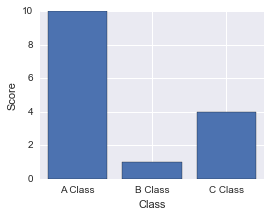

In [143]:
import matplotlib.pyplot as plt

#画像の大きさとバッグカラーの設定
plt.figure(figsize=(4,3),facecolor="white")

# 表示するデータ
X = [1,2,3]
Y = [10,1,4]

# 棒グラフの表示、中央に寄せている
plt.bar(X,Y, align="center")

# グラフそれぞれのレベル
plt.xticks(X, ['A Class','B Class','C Class'])

# XとYのラベル
plt.xlabel("Class")
plt.ylabel("Score")
plt.grid(True)

先ほどは縦の棒グラフでしたが、横にしたい場合は、barhを使います。なお、xの軸とyの軸が入れかわるので、再設定しています。

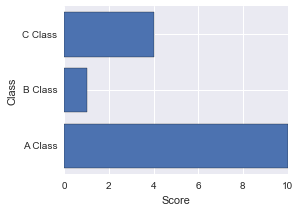

In [144]:
import matplotlib.pyplot as plt

#画像の大きさとバッグカラーの設定
plt.figure(figsize=(4,3),facecolor="white")

X = [1,2,3]
Y = [10,1,4]

plt.barh(X,Y, align="center")
plt.yticks(X, ['A Class','B Class','C Class'])
plt.ylabel("Class")
plt.xlabel("Score")
plt.grid(True)

複数の棒グラフをそれぞれ比較したいという場合があります。以下では、クラスごとに数学の一期目の成績と最終成績を比較できるようにしています。

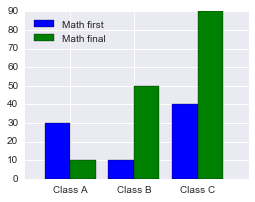

In [145]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(4,3),facecolor="white")

Y1 = np.array([30,10,40])
Y2 = np.array([10,50,90])

X = np.arange(len(Y1))

w=0.4

plt.bar(X, Y1, color='b', width=w, label='Math first', align="center")
plt.bar(X + w, Y2, color='g', width=w, label='Math final', align="center")

plt.legend(loc="best")

plt.xticks(X + w/2, ['Class A','Class B','Class C'])
plt.grid(True)

次は、積み上げの棒グラフです。同じくbarを使い、bottomパラメータの設定に注意してください。

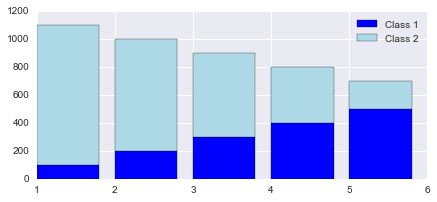

In [146]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3),facecolor="white")

left = np.array([1, 2, 3, 4, 5])

height1 = np.array([100, 200, 300, 400, 500])
height2 = np.array([1000, 800, 600, 400, 200])

p1 = plt.bar(left, height1, color="blue")
p2 = plt.bar(left, height2, bottom=height1, color="lightblue")

plt.legend((p1[0], p2[0]), ("Class 1", "Class 2"))

次は、円グラフです。これは、全体的な割合が各々どれくらいあるのか見るときに使います。pieを使い、それぞれのサイズやラベル等を設定します。axisでグラフの調整をします。autopctでそれぞれの割合を、explodeで特定のカテゴリーだけ、円グラフの全体から離す調整ができます。（ここでは、Hogsを0.1と設定しています。）

(-1.107, 1.028, -1.025, 1.000)

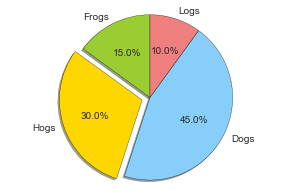

In [147]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3),facecolor="white")

labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0, 0.1, 0, 0) 

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')

scatterを使うことで、バブルチャートも作成できます。

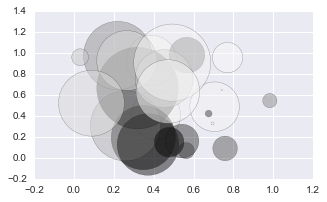

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3),facecolor="white")

N = 25

# X,Y軸
x = np.random.rand(N)
y = np.random.rand(N)

# color番号
colors = np.random.rand(N)

# バブルの大きさ
area = 10*np.pi * (15 * np.random.rand(N))**2

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.grid(True)

以上で、データの可視化は終了です。なお、pandasにも可視化機能が備わっており、.plot()でグラフ化可能です。具体的には、データの後に.plot(kind="bar")で縦の棒グラフが、kind="barh"で横の棒グラフが、kind="pie"で円グラフを表示できます。必要なときに使ってください。また、本節の練習問題以外にも1章のデータ等を使って、色々とグラフ化できますので、実際にどのようなグラフができるか、作成してみましょう。

>**[やってみよう]**

>以下の練習問題以外にもデータを色々とグラフ化してみましょう。どのような目的を持って、どんなグラフを作成しますか?

これまでデータの可視化についてPythonの機能を紹介・実行してきました。しかし、データ分析やデータの可視化が注目されている現在、様々なデータ可視化ツール（タブロ、Excel、PowerBIなど）があるため、ビジネスの現場ではそれらを使う場面が多くなっておりPythonや他のプログラミング言語で可視化する機会は減ってきそうな雰囲気はあります。ただし、可視化レポートの自動化、アプリケーションとの連携、可視化の細かい設定等はプログラミングが勝っているケースもあります。そういった用途でデータの可視化を行うときは是非活用してください。

#### <練習問題 1>

1章で使った学生のデータ（数学）を使って、学校を選んだ理由（reason）を円グラフ化して、それぞれの割合を出してください。

#### <練習問題 2>

上記と同じデータで、higher - 高い教育を受けたいかどうか(binary: yes or no)を軸にして、それぞれの数学の最終成績G3の平均値を棒グラフで表示してください。ここから何か推測できることはありますか？

#### <練習問題 3>

上記と同じデータで、通学時間（trabeltime）を軸にして、それぞれの数学の最終成績G3の平均値を横棒グラフで表示してください。何か推測できることはありますか？

### 4.2.2 応用：金融データの可視化
キーワード：ローソクチャート

ここでは、金融データの可視化について扱っていきます。ただし、応用範囲ですので、スキップしても問題ありません。練習問題もありません。


>pip install plotlyが必要


>[参考URL]


>http://qiita.com/toyolab/items/db8a1e539d4f995079d5



In [152]:
# 日付データの設定、Tで1分ごとにデータ生成
idx = pd.date_range('2015/01/01', '2015/12/31 23:59', freq='T')
# 乱数の発生、１か−１
dn = np.random.randint(2, size=len(idx))*2-1
# ランダムウォーク
rnd_walk = np.cumprod(np.exp(dn*0.0002))*100
# Pandas
df = pd.Series(rnd_walk, index=idx).resample('B').ohlc()

そのままプロットすると以下のようになります。なお、ここではpandasの可視化機能を使っています。

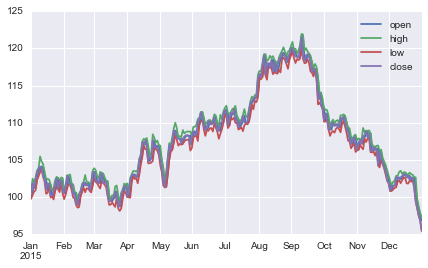

In [153]:
df.plot(figsize=(7,4),legend="best",grid=True)

plotlyのツール、ローソクチャート作成を使えば、以下のように綺麗に表示することが可能です。さらにインタラクティブにグラフをズームインしたり、カーソルを載せると、数字が表示され便利です。

In [155]:
# plotly モジュール
from plotly.offline import init_notebook_mode, iplot
from plotly.tools import FigureFactory as FF

# Jupyter notebook用設定
init_notebook_mode(connected=True) 

# ローソクチャートの設定
fig = FF.create_candlestick(df.open, df.high, df.low, df.close, dates=df.index)
iplot(fig)

***

## 4.3 欠損データと異常値の取り扱いの基礎
ゴール：欠損データと異常値に対する基本的な対処方法を知る

### 4.3.1 欠損データの扱い方
キーワード：リストワイズ削除、ペアワイズ削除、単一代入（平均値代入法）、最尤法、回帰代入法、スプライン補間

データを扱っていると必ずといっていいほど、欠損しているデータや異常値データの存在があります。それぞれ深い分野ですが、ここでは基礎の基礎レベルで欠損データや異常データについての判定や扱い方について学ぶことにします。もっと深く学びたい方は、ぜひ参考文献を読んでください。

>[参考文献]

>『欠損データの統計科学』（高井啓二等、岩波書店）

>『データ分析のプロセス』の第3章（福島真太郎、共立出版）

まずは、欠損データの取り扱いについてです。データの欠損は、入力忘れ、無回答、システム上の問題など様々な要因があります。「ない」データについては、無視をするのがいいのか、除外をするのがいいのか、最もらいしい値を入れるのがいいのか、それが問題です。アプローチによっては、大きなバイアスのある結果を与え、誤った意思決定につながり、大きな損失につながる可能性もあります。慎重に扱っていきましょう。

以下では、欠損データに対して、削除や、0や直前の数字、平均値等で穴埋めをしています。ここでは、これらの単純な方法のみ紹介しますが、他の方法には最尤推定法で推定したり、回帰代入やScipyで実施したスプライン補間などがあります。注意が必要なのは、これらの方法がバイアスを生む可能性があることです。深く学びたい方はぜひ上で紹介した参考文献などを読んで、欠損データを埋める方法への理解を深めてください。

In [156]:
# データの準備
import numpy as np
from numpy import nan as NA
import pandas as pd


sample_data_frame = pd.DataFrame(np.random.rand(10,4))

# NAにする
sample_data_frame.ix[1,0] = NA
sample_data_frame.ix[2:3,2] = NA
sample_data_frame.ix[5:,3] = NA

sample_data_frame

,0,1,2,3
0,0.177819,0.222117,0.486475,0.006296
1,NaN,0.158295,0.673255,0.827461
2,0.901311,0.734064,NaN,0.342624
3,0.755374,0.636622,NaN,0.867675
4,0.528520,0.868874,0.423066,0.263671
5,0.126543,0.991663,0.475745,NaN
6,0.439666,0.737574,0.316719,NaN
7,0.314023,0.726507,0.944106,NaN
8,0.664903,0.353893,0.526415,NaN
9,0.623824,0.287629,0.468715,NaN


NaNがある行はすべて取り除くのは、dropnaを使います。これを**リストワイズ削除**といいます。以下は、すべてのカラムにデータがある行だけ表示しています。

In [157]:
sample_data_frame.dropna()

,0,1,2,3
0,0.177819,0.222117,0.486475,0.006296
4,0.528520,0.868874,0.423066,0.263671


一方、元々10行あったデータが極端に少なくなって2行になり、データが全く使えないという状況を考えましょう。このとき、欠損している列のデータを無視して、利用可能なデータのみ（例：列の0番目と1番目のみ存在）を使う方法があります。これを**ペアワイズ削除**といいます。

In [158]:
sample_data_frame[[0,1]].dropna()

,0,1
0,0.177819,0.222117
2,0.901311,0.734064
3,0.755374,0.636622
4,0.528520,0.868874
5,0.126543,0.991663
6,0.439666,0.737574
7,0.314023,0.726507
8,0.664903,0.353893
9,0.623824,0.287629


fillna(値)で、値で埋めます。以下は0で置き換えています。

In [159]:
sample_data_frame.fillna(0)

,0,1,2,3
0,0.177819,0.222117,0.486475,0.006296
1,0.000000,0.158295,0.673255,0.827461
2,0.901311,0.734064,0.000000,0.342624
3,0.755374,0.636622,0.000000,0.867675
4,0.528520,0.868874,0.423066,0.263671
5,0.126543,0.991663,0.475745,0.000000
6,0.439666,0.737574,0.316719,0.000000
7,0.314023,0.726507,0.944106,0.000000
8,0.664903,0.353893,0.526415,0.000000
9,0.623824,0.287629,0.468715,0.000000


methodを指定することで、前の値で埋めてくれます。

In [160]:
sample_data_frame.fillna(method="ffill")

,0,1,2,3
0,0.177819,0.222117,0.486475,0.006296
1,0.177819,0.158295,0.673255,0.827461
2,0.901311,0.734064,0.673255,0.342624
3,0.755374,0.636622,0.673255,0.867675
4,0.528520,0.868874,0.423066,0.263671
5,0.126543,0.991663,0.475745,0.263671
6,0.439666,0.737574,0.316719,0.263671
7,0.314023,0.726507,0.944106,0.263671
8,0.664903,0.353893,0.526415,0.263671
9,0.623824,0.287629,0.468715,0.263671


他、平均値でも穴埋めすることができます。これを**平均値代入法**といいます。

In [161]:
# 各カラムの平均値(確認用)
sample_data_frame.mean()

0    0.503554
1    0.571724
2    0.539312
3    0.461545
dtype: float64

In [162]:
sample_data_frame.fillna(sample_data_frame.mean())

,0,1,2,3
0,0.177819,0.222117,0.486475,0.006296
1,0.503554,0.158295,0.673255,0.827461
2,0.901311,0.734064,0.539312,0.342624
3,0.755374,0.636622,0.539312,0.867675
4,0.528520,0.868874,0.423066,0.263671
5,0.126543,0.991663,0.475745,0.461545
6,0.439666,0.737574,0.316719,0.461545
7,0.314023,0.726507,0.944106,0.461545
8,0.664903,0.353893,0.526415,0.461545
9,0.623824,0.287629,0.468715,0.461545


他にも色々とオプションがあるので、?sample_data_frame.fillna等で調べてみてください。

欠損データについて、今回はサンプルデータにおいて、一定の値を機械的に置換しました。ただし、これらの方法はいつも使えるというわけではありません。データの状況、背景等を考え、適切に対処することが重要です。

#### <練習問題 1>

以下のデータに対して、1列でもNaNがある場合は削除し、その結果を表示してください。

In [163]:
# データの準備
import numpy as np
from numpy import nan as NA
import pandas as pd


sample_data_frame2 = pd.DataFrame(np.random.rand(15,6))

# NAにする
sample_data_frame2.ix[2,0] = NA
sample_data_frame2.ix[5:8,2] = NA
sample_data_frame2.ix[7:9,3] = NA
sample_data_frame2.ix[10,5] = NA


sample_data_frame2

,0,1,2,3,4,5
0,0.415247,0.550350,0.557778,0.383570,0.482254,0.142117
1,0.066697,0.908009,0.197264,0.227380,0.291084,0.305750
2,NaN,0.481305,0.963701,0.289538,0.662069,0.883058
3,0.469084,0.717253,0.467172,0.661786,0.539626,0.862264
4,0.314643,0.129364,0.291149,0.210694,0.891432,0.583443
5,0.672456,0.111327,NaN,0.197844,0.361385,0.703919
6,0.943599,0.047140,NaN,0.222312,0.270678,0.985113
7,0.172857,0.359706,NaN,NaN,0.559918,0.181495
8,0.650042,0.845300,NaN,NaN,0.706246,0.634860
9,0.696152,0.353721,0.999253,NaN,0.616951,0.278251


#### <練習問題 2>

上記で準備したデータに対して、NaNを0で埋めてください。

#### <練習問題 3>

上記で準備したデータに対して、NaNをそれぞれの列の平均値で埋めてください。

### 4.3.2 異常データの扱い方
キーワード：異常値、箱ひげ図、パーセンタイル、VaR(Value At Risk)

異常値（外れ値）データの扱いは、そのままにして何もしないのか、異常値を除去するか、もっともらしい値に入れかえて使うかが問題になります。そもそも異常値とは一体何でしょうか。実は、統一的な見解というものはなく、そのデータを扱うアナリストや意思決定者が判断することもあります。ビジネスの現場では、不正アクセスのパターン（セキュリティ分野）や機械の故障、金融リスク管理（VaR）など、様々な分野で使われており、それぞれ色々な方法でアプローチされています。

異常値検出のアプローチには、単純には箱ひげ図などを書いて、あるパーセンタイル以上のデータを異常値としてみなす方法、正規分布を利用する方法、データの空間的な近さに基づく方法などがあります。他には以降の章で学ぶ機械学習（教師なし学習も含む）を用いた方法があります。

ここでは特に練習問題はありませんが、興味のある方は以下の参考文献などでぜひ学んでください。

>[参考文献]

>『入門 機械学習による異常検知―Rによる実践ガイド』（井手剛、コロナ社）

>『異常検知と変化検知』（井手剛等、講談社）


>[参考URL]

>http://qiita.com/GushiSnow/items/f032806cfa8cec046318

>http://qiita.com/shopetan/items/ceb7744facc21c3881d2

>http://www.slideshare.net/shoheihido/fit2012

以上で、2章の解説は終了です。長い時間、お疲れさまでした。少し単調な説明が多かったかもしれませんが、次の総合問題で、実践していきましょう。

***

## 4.4 総合問題

### 4.4.1 時系列データ分析

ここでは、本章で身に付けたpandasやscipyなどを使って、時系列データや購買データについて扱っていきましょう。まずは、時系列のデータです。

（1）（データの取得と確認）下記のサイトより、dow_jones_index.zipをダウンロードし、中にあるdow_jones_index.dataを使って、データを読み込み、はじめの5行を表示してください。またデータのそれぞれのカラム情報等を見て、nullなどがあるか確認してください。　　

https://archive.ics.uci.edu/ml/machine-learning-databases/00312/dow_jones_index.zip　　

（2）（データの加工）カラムのopen、high、low、close等のデータは数字の前に$マークが付いているため、これを取り除いてください。また、日時をdate型で読み込んでいない場合は、date型に変換しましょう。

（3）カラムのcloseについて、各stockごとの要約統計量を算出してください。

（4）カラムのcloseについて、各stockの相関を算出する相関行列を出してください。また、seabornのheatmapを使って、相関行列のヒートマップを描いてみましょう。（ヒント：pandasのcorr()を使います。）

（5）(4)で算出した相関行列の中で一番相関係数が高いstockの組み合わせを抽出してください。さらに、その中でもっとも相関係数が高いペアを抜き出し、それぞれの時系列グラフを書いてください。

（6） pandasのrollingとwindow関数（窓関数）を使って、上記で使った各stockごとに、closeの過去5期（5週間）移動平均時系列データを計算してください。

（7） pandasのshift()を使って、上記で使った各stockごとに、closeの前期（1週前）との比の対数時系列データを計算してください。さらに、この中で、一番ボラティリティ（標準偏差）が一番大きいstockと小さいstockを抜き出し、その対数変化率グラフを書いてください。

※(6),(7)の補足

時系列データ$(\cdots ,y_{t-1},y_t,y_{t+1}, \cdots )$の過去n期の移動平均データとは、過去5期のデータの平均、

\begin{eqnarray}
ma_t = \sum_{s=t-n+1}^t \frac{y_s}{n}
\end{eqnarray}

時系列データ$(\cdots ,y_{t-1},y_t,y_{t+1}, \cdots )$の前期（1週前）との比の対数時系列データとは、$\log \frac{y_t} {y_{t-1}}$から成るデータの事です。増減率$r_t = \frac{y_t - y_{t-1}}{y_t}$が小さいとき、$r_t \approx \log \frac{y_t} {y_{t-1}}$の関係が成り立ちます。これは、$x$が十分小さいときに成り立つ、$\log (1+x) \approx x$から導かれます。増減率データ$(r_1,\cdots ,r_N )$のボラティリティとは、標準偏差

\begin{eqnarray}
\sqrt{\frac{1}{N}\sum_{t=1}^N (r_t - \frac{1}{N}\sum_{t=1}^N r_t)^2}
\end{eqnarray}

の事で、価格変動の大きさを示す指標として利用されます。

### 4.4.2 マーケティング分析

次は、マーケティング分析でよく扱われる購買データです。一般ユーザーとは異なる法人の購買データですが、分析する軸は基本的に同じです。

（1）下記のURLよりデータをpandasで読み込んでください（件数50万以上のデータで比較的大きいため、少し時間がかかります。）

    "http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
    
    (ヒント)pd.ExcelFileを使って、シートを.parse('Online Retail')で指定してください。
    
    また、今回の分析対象は、CustomerIDにデータが入っているレコードのみ対象にするため、そのための処理をしてください。さらに、カラムのInvoiceNoには数字の前にCがあるものはキャンセルのため、このデータを取り除いてください。他にもデータとして取り除く必要なものがあれば、適宜処理してください。以下、このデータをベースに分析していきます。

（2）このデータのカラムには、購買日時や商品名、数量、回数、購買者のIDなどがあります。ここで、購買者（CustomerID）のユニーク数、バスケット数（InvoiceNoのユニーク数）、商品の種類（StockCodeベースとDescriptionベースのユニーク数）を求めてください。

（3）このデータのカラムには、Countryがあります。このカラムを軸に、それぞれの国の購買合計金額（単位あたりの金額×数量の合計）を求め、降順にならべて、上位5つの国の結果を表示してください。

（4）上の上位5つの国について、それぞれの国の商品売り上げ（合計金額）の月別の時系列推移をグラフにしてください。ここで、グラフは分けて表示してください。

（5）上の上位5つの国について、それぞれの国における商品の売り上げTOP5の商品を抽出してください。また、それらを国ごとに円グラフにしてください。なお、商品は「Description」ベースで集計してください。